In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
df = pd.read_csv('backtest.csv')

In [3]:
df

Date          Open          High           Low         Close  \
0     2015-01-01    320.434998    320.434998    314.002991    314.248993   
1     2015-01-02    314.079010    315.838989    313.565002    315.032013   
2     2015-01-03    314.846008    315.149994    281.082001    281.082001   
3     2015-01-04    281.145996    287.230011    257.612000    264.195007   
4     2015-01-05    265.084015    278.341003    265.084015    274.473999   
...          ...           ...           ...           ...           ...   
3564  2024-10-04  60754.625000  62465.992188  60459.941406  62067.476562   
3565  2024-10-05  62067.609375  62371.023438  61689.582031  62089.949219   
3566  2024-10-06  62084.988281  62959.570312  61833.148438  62818.953125   
3567  2024-10-07  62819.109375  64443.707031  62152.550781  62236.660156   
3568  2024-10-08  62221.644531  63174.304688  61843.562500  62131.968750   

           Volume       BTC-USD  Rolling_Low(Close, 10)  SMA(Close, 100)  \
0         8036550    314.248993                     NaN              NaN   
1         7860650    315.032013                     NaN              NaN   
2        33054400    281.082001                     NaN              NaN   
3        55629100    264.195007                     NaN              NaN   
4        43962800    274.473999                     NaN              NaN   
...           ...           ...                     ...              ...   
3564  29585472513  62067.476562            60632.785156     61037.844883   
3565  13305410749  62089.949219            60632.785156     61050.406875   
3566  14776233667  62818.953125            60632.785156     61055.258359   
3567  34253562610  62236.660156            60632.785156     61080.246523   
3568  28134475157  62131.968750            60632.785156     61093.739336   

      SMA(Close, 50)  ...  cumulative_returns  cumulative_market_returns  \
0                NaN  ...                 NaN                        NaN   
1                NaN  ...                 NaN                   0.002492   
2                NaN  ...            0.000000                  -0.105544   
3                NaN  ...            0.000000                  -0.159281   
4                NaN  ...            0.000000                  -0.126572   
...              ...  ...                 ...                        ...   
3564    60379.240547  ...          377.268976                 196.510503   
3565    60469.388125  ...          377.268976                 196.582015   
3566    60533.305000  ...          377.268976                 198.901844   
3567    60600.104609  ...          377.268976                 197.048877   
3568    60675.158516  ...          377.268976                 196.715729   

      portfolio_drawdown  market_drawdown  Long Breakout_drawdown  \
0                    NaN              NaN                     NaN   
1                    NaN         0.000000                     NaN   
2               0.000000         0.107767                0.000000   
3               0.000000         0.161371                0.000000   
4               0.000000         0.128743                0.000000   
...                  ...              ...                     ...   
3564            0.122524         0.150732                0.180478   
3565            0.122524         0.150425                0.180478   
3566            0.122524         0.140450                0.180478   
3567            0.122524         0.148417                0.180478   
3568            0.122524         0.149850                0.180478   

      Quick Short Momentum_drawdown  portfolio_rolling_sharpe  \
0                               NaN                       NaN   
1                               NaN                       NaN   
2                               0.0                       NaN   
3                               0.0                       NaN   
4                               0.0                       NaN   
...                             ...                   

In [8]:
def process_trade(trade_df):
    entry_date = trade_df['Date'].iloc[0]
    exit_date = trade_df['Date'].iloc[-1]
    delta_pos = trade_df['delta_position']
    Close = trade_df['Close']
    initial_position = trade_df['position'].iloc[0]

    if initial_position > 0:
        # Long trade
        trade_type = 'Long'
        # Entry when delta_pos > 0
        delta_pos_entry = delta_pos[delta_pos > 0]
        Close_entry = Close[delta_pos > 0]
        total_pos_entry = delta_pos_entry.sum()

        # Exit when delta_pos < 0
        delta_pos_exit = delta_pos[delta_pos < 0]
        Close_exit = Close[delta_pos < 0]
        total_pos_exit = delta_pos_exit.sum()  # Negative of negative values

        # Trade return: (avg_exit_price - avg_entry_price) / avg_entry_price
        calc_trade_return = lambda avg_entry_price, avg_exit_price: (avg_exit_price - avg_entry_price) / avg_entry_price

    elif initial_position < 0:
        # Short trade
        trade_type = 'Short'
        # Entry when delta_pos < 0 (position decreases, more negative)
        delta_pos_entry = -delta_pos[delta_pos < 0]  # Convert to positive quantities
        Close_entry = Close[delta_pos < 0]
        total_pos_entry = delta_pos_entry.sum()

        # Exit when delta_pos > 0 (position increases towards zero)
        delta_pos_exit = delta_pos[delta_pos > 0]
        Close_exit = Close[delta_pos > 0]
        total_pos_exit = delta_pos_exit.sum()

        # Trade return: (avg_entry_price - avg_exit_price) / avg_entry_price
        calc_trade_return = lambda avg_entry_price, avg_exit_price: (avg_entry_price - avg_exit_price) / avg_entry_price

    else:
        # Should not occur, but handle just in case
        trade_type = 'Flat'
        total_pos_entry = 0
        total_pos_exit = 0
        avg_entry_price = np.nan
        avg_exit_price = np.nan
        trade_return = np.nan
        return pd.Series({
            'Entry Date': entry_date,
            'Exit Date': exit_date,
            'Average Entry Price': avg_entry_price,
            'Average Exit Price': avg_exit_price,
            'Trade Return': trade_return,
            'Trade Type': trade_type
        })

    # Calculate average entry price
    if total_pos_entry != 0:
        avg_entry_price = (delta_pos_entry * Close_entry).sum() / total_pos_entry
    else:
        avg_entry_price = np.nan

    # Calculate average exit price
    if total_pos_exit != 0:
        avg_exit_price = (delta_pos_exit * Close_exit).sum() / total_pos_exit
    else:
        avg_exit_price = np.nan

    # Calculate trade return
    if not np.isnan(avg_entry_price) and not np.isnan(avg_exit_price):
        trade_return = calc_trade_return(avg_entry_price, avg_exit_price)
    else:
        trade_return = np.nan

    return pd.Series({
        'Entry Date': entry_date,
        'Exit Date': exit_date,
        'Average Entry Price': avg_entry_price,
        'Average Exit Price': avg_exit_price,
        'Position': -total_pos_exit,
        'Trade Return': trade_return,
        'Trade Type': trade_type
    })
    

def trade_analysis(data, strategy):
    df = data.copy()
    df = df[['Date', 'Close', f'{strategy}_position']].dropna()
    df['position'] = df[f'{strategy}_position']
    # Step 1: Compute position and delta_position
    df['delta_position'] = df['position'].diff().fillna(0)

    # Step 2: Identify entries and exits, and assign trade_ids
    df['entry_mask'] = ((df['position'].shift(1).fillna(0) == 0) & (df['position'] != 0)).astype(int)
    df['trade_id'] = df['entry_mask'].cumsum()

    # **Fix: Only set trade_id to NaN when position is zero and there's no position change**
    df.loc[(df['position'] == 0) & (df['delta_position'] == 0), 'trade_id'] = np.nan
        # Step 4: Apply the function to each trade
    df_valid_trades = df[df['trade_id'].notnull()]
    trades = df_valid_trades.groupby('trade_id').apply(process_trade).reset_index(drop=True)
    trades['strategy'] = strategy

    return trades

In [5]:
df['Quick Short Momentum_position'] = -df['Quick Short Momentum_position']

In [11]:
trades = trade_analysis(df, 'Long Breakout')

/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_1207/967088186.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trades = df_valid_trades.groupby('trade_id').apply(process_trade).reset_index(drop=True)


In [12]:
trades

Entry Date   Exit Date  Average Entry Price  Average Exit Price  Position  \
0   2015-03-02  2015-03-19           277.073536          260.928009  0.694286   
1   2015-06-17  2015-08-04           249.717548          282.740789  1.829526   
2   2015-10-07  2015-11-12           247.301406          351.565345  1.598251   
3   2015-12-06  2015-12-27           393.006649          422.854370  0.813691   
4   2016-02-19  2016-03-05           422.240598          400.570007  1.014179   
5   2016-04-16  2016-05-03           432.763285          450.318369  2.570496   
6   2016-05-28  2016-06-23           530.039978          607.037075  2.250334   
7   2016-09-04  2016-09-18           609.224483          609.874023  1.566369   
8   2016-10-12  2017-01-07           659.606849          845.319872  3.137433   
9   2017-02-05  2017-03-09          1061.042391         1188.489990  1.072747   
10  2017-04-19  2017-06-15          1277.076485         2404.783635  1.076337   
11  2017-07-21  2017-09-05          2924.462064         3950.498786  0.844258   
12  2017-10-09  2017-10-25          4877.889844         5750.799805  0.596865   
13  2017-10-30  2017-11-12          6215.705129         5950.069824  0.695922   
14  2017-11-17  2017-12-22          7989.312755        14459.621580  0.707664   
15  2018-03-04  2018-03-09         11465.134125         9337.549805  0.447555   
16  2018-04-22  2018-05-11          8843.984979         8449.505008  0.659348   
17  2018-07-18  2018-08-03          7374.113962         7459.676820  0.925345   
18  2018-09-05  2018-09-07          6789.137262         6467.069824  1.003637   
19  2019-02-19  2019-03-05          3946.819078         3894.916434  1.100872   
20  2019-03-30  2019-06-05          4286.487495         6891.581682  1.707864   
21  2019-06-16  2019-07-15          9116.483904        11020.381652  0.779704   
22  2019-10-26  2019-11-09          9244.972656         8950.917671  1.119908   
23  2020-01-07  2020-01-26          8166.215350         8596.686866  1.082732   
24  2020-01-29  2020-02-18          9369.189872        10141.927657  1.158653   
25  2020-04-24  2020-05-12          7770.411240         8804.477539  0.618054   
26  2020-06-02  2020-06-12          9536.688016         9480.907658  0.765783   
27  2020-07-26  2020-08-26          9967.031631        11469.901411  1.641574   
28  2020-10-11  2020-11-28         11460.791101        17153.989143  1.467420   
29  2020-12-01  2020-12-11         18802.998047        18159.679427  1.016652   
30  2020-12-17  2021-01-22         22879.594768        33032.176634  0.919396   
31  2021-02-09  2021-02-26         46560.910920        46408.285371  0.613046   
32  2021-03-12  2021-03-23         57363.692190        54738.945312  0.622338   
33  2021-04-14  2021-04-19         62997.492790        55724.265625  0.843396   
34  2021-07-27  2021-09-08         40667.317329        46091.451014  0.877047   
35  2021-10-07  2021-10-27         54134.493635        58415.442936  0.791263   
36  2021-11-09  2021-11-17         66819.217167        60368.011719  0.895036   
37  2022-02-09  2022-02-18         44337.589789        40112.189864  0.938004   
38  2022-03-27  2022-04-07         46727.820529        43503.847656  0.828486   
39  2022-07-19  2022-08-20         23360.743856        21174.470994  0.941973   
40  2022-10-27  2022-11-09         20311.267995        15880.780273  1.389748   
41  2022-12-14  2022-12-17         17792.555119        16795.091797  0.980405   
42  2023-01-12  2023-02-07         18891.946245        23116.180224  1.559219   
43  2023-02-16  2023-02-26         23623.474609        23661.815609  1.302758   
44  2023-03-17  2023-04-21         27710.677910        27339.870653  1.227597   
45  2023-06-21  2023-07-07         30038.876105        30349.162242  1.389666   
46  2023-07-14  2023-07-18         30333.206548        29856.562500  1.409092   
47  2023-10-02  2023-10-12         27529.656843        26756.798828  1.792624   
48  2023-10-17  2023-12-30         

In [13]:
TRADES_DF = []
for strategy in ['Quick Short Momentum', 'Long Breakout']:
    trades = trade_analysis(df, strategy)
    TRADES_DF.append(trades)

trades_df = pd.concat([TRADES_DF[i] for i in range(len(TRADES_DF))], axis=0)
trades_df['Entry Date'] = pd.to_datetime(trades_df['Entry Date'])
trades_df.sort_values(by='Entry Date', inplace=True)

/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_1207/967088186.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trades = df_valid_trades.groupby('trade_id').apply(process_trade).reset_index(drop=True)
/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_1207/967088186.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trades = df_valid_trades.groupby('trade_id').apply(process_trade)

In [14]:
trades_df

Entry Date   Exit Date  Average Entry Price  Average Exit Price  Position  \
0  2015-03-02  2015-03-19           277.073536          260.928009  0.694286   
0  2015-04-12  2015-05-25           236.153000          237.110001 -0.200000   
1  2015-06-04  2015-06-17           224.324005          249.283997 -0.200000   
1  2015-06-17  2015-08-04           249.717548          282.740789  1.829526   
2  2015-08-19  2015-10-06           226.684006          246.063004 -0.200000   
..        ...         ...                  ...                 ...       ...   
39 2024-07-18  2024-07-20         63974.066406        67163.648438 -0.200000   
52 2024-07-20  2024-08-01         67153.236377        65409.067951  1.282933   
40 2024-08-07  2024-08-24         55027.460938        64178.992188 -0.200000   
41 2024-08-31  2024-09-19         58969.898438        62940.457031 -0.200000   
53 2024-09-27  2024-10-02         65693.854486        60632.785156  1.136139   

    Trade Return Trade Type              strategy  
0      -0.058272       Long         Long Breakout  
0      -0.004052      Short  Quick Short Momentum  
1      -0.111268      Short  Quick Short Momentum  
1       0.132242       Long         Long Breakout  
2      -0.085489      Short  Quick Short Momentum  
..           ...        ...                   ...  
39     -0.049857      Short  Quick Short Momentum  
52     -0.025973       Long         Long Breakout  
40     -0.166308      Short  Quick Short Momentum  
41     -0.067332      Short  Quick Short Momentum  
53     -0.077040       Long         Long Breakout  

[96 rows x 8 columns]

In [9]:
trade_analysis(df, 'total')

/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_978/13239257.py:100: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trades = df_valid_trades.groupby('trade_id').apply(process_trade).reset_index(drop=True)


Entry Date   Exit Date  Average Entry Price  Average Exit Price  \
0   2015-03-02  2015-03-19           277.073536          260.928009   
1   2015-04-12  2015-05-25           236.153000          237.110001   
2   2015-06-04  2015-08-04           246.988974          282.740789   
3   2015-08-19  2015-10-06           226.684006          246.063004   
4   2015-10-07  2015-11-12           247.301406          351.565345   
..         ...         ...                  ...                 ...   
73  2024-06-21  2024-07-16         64096.199219        65097.148438   
74  2024-07-18  2024-08-01         66656.003693        65409.067951   
75  2024-08-07  2024-08-24         55027.460938        64178.992188   
76  2024-08-31  2024-09-19         58969.898438        62940.457031   
77  2024-09-27  2024-10-02         65693.854486        60632.785156   

    Trade Return Trade Type  
0      -0.058272       Long  
1       0.004052       Long  
2       0.144751       Long  
3       0.085489       Long  
4       0.421607       Long  
..           ...        ...  
73      0.015616       Long  
74     -0.018707       Long  
75      0.166308       Long  
76      0.067332       Long  
77     -0.077040       Long  

[78 rows x 6 columns]

In [8]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'BTC-USD',
       'Rolling_Low(Close, 10)', 'SMA(Close, 100)', 'SMA(Close, 50)',
       'Rolling_High(Close, 30)', 'SMA(Close, 7)', 'Rolling_High(Close, 5)',
       'Long Breakout_signal', 'Long Breakout_position_size',
       'Long Breakout_position', 'Long Breakout_returns',
       'Long Breakout_log_returns', 'Long Breakout_cumulative_equity',
       'Long Breakout_cumulative_returns',
       'Long Breakout_cumulative_log_equity', 'Quick Short Momentum_signal',
       'Quick Short Momentum_position_size', 'Quick Short Momentum_position',
       'Quick Short Momentum_returns', 'Quick Short Momentum_log_returns',
       'Quick Short Momentum_cumulative_equity',
       'Quick Short Momentum_cumulative_returns',
       'Quick Short Momentum_cumulative_log_equity', 'total_position',
       'returns', 'log_returns', 'gross_portfolio_returns',
       'gross_portfolio_log_returns', 'trades', 'transaction_costs',
       'portfolio_retu

In [14]:
df.loc[df.Date>='2015-04-12'][['Date', 'Close']].head(30)

Date       Close
101  2015-04-12  236.153000
102  2015-04-13  224.587006
103  2015-04-14  219.158997
104  2015-04-15  223.832993
105  2015-04-16  228.572998
106  2015-04-17  222.882004
107  2015-04-18  223.356003
108  2015-04-19  222.600006
109  2015-04-20  224.626007
110  2015-04-21  235.268997
111  2015-04-22  234.175995
112  2015-04-23  236.462006
113  2015-04-24  231.268005
114  2015-04-25  226.389999
115  2015-04-26  219.429993
116  2015-04-27  229.285995
117  2015-04-28  225.854996
118  2015-04-29  225.807999
119  2015-04-30  236.145004
120  2015-05-01  232.078995
121  2015-05-02  234.929993
122  2015-05-03  240.358002
123  2015-05-04  239.018005
124  2015-05-05  236.121002
125  2015-05-06  229.781998
126  2015-05-07  237.334000
127  2015-05-08  243.863007
128  2015-05-09  241.832001
129  2015-05-10  240.296005
130  2015-05-11  242.158005

In [13]:
trades

Entry Date   Exit Date  Average Entry Price  Average Exit Price  \
0   2015-04-12  2015-05-25           236.153000          237.110001   
1   2015-06-04  2015-06-17           224.324005          249.283997   
2   2015-08-19  2015-10-06           226.684006          246.063004   
3   2016-01-29  2016-02-15           379.473999          400.184998   
4   2016-08-03  2016-08-08           566.354980          591.054016   
5   2016-08-12  2016-09-09           587.559021          622.861023   
6   2017-03-25  2017-03-29           972.778992         1039.969971   
7   2017-07-16  2017-07-21          1929.819946         2667.760010   
8   2018-01-23  2018-01-28         10868.400391        11786.299805   
9   2018-01-30  2018-03-05         10106.299805        11573.299805   
10  2018-03-13  2018-04-24          9194.849609         9697.500000   
11  2018-05-22  2018-07-24          8041.779785         8424.269531   
12  2018-08-11  2018-08-29          6295.729980         7047.160156   
13  2018-09-09  2019-02-20          6300.859863         3999.820557   
14  2019-08-29  2019-09-03          9510.200195        10623.540039   
15  2019-09-12  2019-11-05         10410.126953         9342.527344   
16  2019-11-21  2020-01-08          7642.750000         8079.862793   
17  2020-03-09  2020-04-24          7923.644531         7550.900879   
18  2020-09-09  2020-09-12         10242.347656        10442.170898   
19  2020-09-24  2020-09-28         10760.066406        10709.652344   
20  2021-04-26  2021-04-27         54021.753906        55033.117188   
21  2021-05-14  2021-07-29         49880.535156        40008.421875   
22  2021-09-29  2021-10-01         41564.363281        48116.941406   
23  2021-11-27  2021-11-30         54815.078125        57005.425781   
24  2021-12-04  2022-02-16         49200.703125        43961.859375   
25  2022-02-23  2022-03-10         37296.570312        39437.460938   
26  2022-03-11  2022-03-23         38794.972656        42892.957031   
27  2022-04-14  2022-04-20         39935.515625        41374.378906   
28  2022-04-22  2022-07-28         39740.320312        23843.886719   
29  2022-08-24  2022-09-13         21395.019531        20296.707031   
30  2022-09-14  2022-10-30         20241.089844        20635.603516   
31  2022-11-12  2023-01-10         16799.185547        17446.292969   
32  2023-03-11  2023-03-14         20632.410156        24746.074219   
33  2023-05-25  2023-05-29         26476.207031        27745.884766   
34  2023-06-02  2023-06-21         27249.589844        30027.296875   
35  2023-08-18  2023-10-08         26049.556641        27935.089844   
36  2024-05-02  2024-05-05         59123.433594        64031.132812   
37  2024-05-11  2024-05-16         60793.710938        65231.582031   
38  2024-06-21  2024-07-16         64096.199219        65097.148438   
39  2024-07-18  2024-07-20         63974.066406        67163.648438   
40  2024-08-07  2024-08-24         55027.460938        64178.992188   
41  2024-08-31  2024-09-19         58969.898438        62940.457031   

    Trade Return Trade Type  
0      -0.004052      Short  
1      -0.111268      Short  
2      -0.085489      Short  
3      -0.054578      Short  
4      -0.043611      Short  
5      -0.060082      Short  
6      -0.069071      Short  
7      -0.382388      Short  
8      -0.084456      Short  
9      -0.145157      Short  
10     -0.054667      Short  
11     -0.047563      Short  
12     -0.119356      Short  
13      0.365194      Short  
14     -0.117068      Short  
15      0.102554      Short  
16     -0.057193      Short  
17      0.047042      Short  
18     -0.019510      Short  
19      0.004685      Short  
20     -0.018721      Short  
21      0.197915      Short  
22     -0.157649      Short  
23     -0.039959      Short  
24      0.106479      Short  
25     -0.057402      Short  
26     -0.105632      Short  
27     -0.036030      Short  
28      0.400008      Short  
29      0.051335      Short  
30     -0.019491    

In [10]:
df.loc[df.Date>='2015-04-12'].head(20)[['Date', 'Close', 'Quick Short Momentum_position']]

Date       Close  Quick Short Momentum_position
101  2015-04-12  236.153000                            0.2
102  2015-04-13  224.587006                            0.2
103  2015-04-14  219.158997                            0.2
104  2015-04-15  223.832993                            0.2
105  2015-04-16  228.572998                            0.2
106  2015-04-17  222.882004                            0.2
107  2015-04-18  223.356003                            0.2
108  2015-04-19  222.600006                            0.2
109  2015-04-20  224.626007                            0.2
110  2015-04-21  235.268997                            0.2
111  2015-04-22  234.175995                            0.2
112  2015-04-23  236.462006                            0.2
113  2015-04-24  231.268005                            0.2
114  2015-04-25  226.389999                            0.2
115  2015-04-26  219.429993                            0.2
116  2015-04-27  229.285995                            0.2
117  2015-04-28  225.854996                            0.2
118  2015-04-29  225.807999                            0.2
119  2015-04-30  236.145004                            0.2
120  2015-05-01  232.078995                            0.2

In [8]:
trades

Entry Date   Exit Date  Average Entry Price  Average Exit Price  \
0   2015-04-12  2015-05-25           236.153000          237.110001   
1   2015-06-04  2015-06-17           224.324005          249.283997   
2   2015-08-19  2015-10-06           226.684006          246.063004   
3   2016-01-29  2016-02-15           379.473999          400.184998   
4   2016-08-03  2016-08-08           566.354980          591.054016   
5   2016-08-12  2016-09-09           587.559021          622.861023   
6   2017-03-25  2017-03-29           972.778992         1039.969971   
7   2017-07-16  2017-07-21          1929.819946         2667.760010   
8   2018-01-23  2018-01-28         10868.400391        11786.299805   
9   2018-01-30  2018-03-05         10106.299805        11573.299805   
10  2018-03-13  2018-04-24          9194.849609         9697.500000   
11  2018-05-22  2018-07-24          8041.779785         8424.269531   
12  2018-08-11  2018-08-29          6295.729980         7047.160156   
13  2018-09-09  2019-02-20          6300.859863         3999.820557   
14  2019-08-29  2019-09-03          9510.200195        10623.540039   
15  2019-09-12  2019-11-05         10410.126953         9342.527344   
16  2019-11-21  2020-01-08          7642.750000         8079.862793   
17  2020-03-09  2020-04-24          7923.644531         7550.900879   
18  2020-09-09  2020-09-12         10242.347656        10442.170898   
19  2020-09-24  2020-09-28         10760.066406        10709.652344   
20  2021-04-26  2021-04-27         54021.753906        55033.117188   
21  2021-05-14  2021-07-29         49880.535156        40008.421875   
22  2021-09-29  2021-10-01         41564.363281        48116.941406   
23  2021-11-27  2021-11-30         54815.078125        57005.425781   
24  2021-12-04  2022-02-16         49200.703125        43961.859375   
25  2022-02-23  2022-03-10         37296.570312        39437.460938   
26  2022-03-11  2022-03-23         38794.972656        42892.957031   
27  2022-04-14  2022-04-20         39935.515625        41374.378906   
28  2022-04-22  2022-07-28         39740.320312        23843.886719   
29  2022-08-24  2022-09-13         21395.019531        20296.707031   
30  2022-09-14  2022-10-30         20241.089844        20635.603516   
31  2022-11-12  2023-01-10         16799.185547        17446.292969   
32  2023-03-11  2023-03-14         20632.410156        24746.074219   
33  2023-05-25  2023-05-29         26476.207031        27745.884766   
34  2023-06-02  2023-06-21         27249.589844        30027.296875   
35  2023-08-18  2023-10-08         26049.556641        27935.089844   
36  2024-05-02  2024-05-05         59123.433594        64031.132812   
37  2024-05-11  2024-05-16         60793.710938        65231.582031   
38  2024-06-21  2024-07-16         64096.199219        65097.148438   
39  2024-07-18  2024-07-20         63974.066406        67163.648438   
40  2024-08-07  2024-08-24         55027.460938        64178.992188   
41  2024-08-31  2024-09-19         58969.898438        62940.457031   

    Trade Return Trade Type  
0       0.004052       Long  
1       0.111268       Long  
2       0.085489       Long  
3       0.054578       Long  
4       0.043611       Long  
5       0.060082       Long  
6       0.069071       Long  
7       0.382388       Long  
8       0.084456       Long  
9       0.145157       Long  
10      0.054667       Long  
11      0.047563       Long  
12      0.119356       Long  
13     -0.365194       Long  
14      0.117068       Long  
15     -0.102554       Long  
16      0.057193       Long  
17     -0.047042       Long  
18      0.019510       Long  
19     -0.004685       Long  
20      0.018721       Long  
21     -0.197915       Long  
22      0.157649       Long  
23      0.039959       Long  
24     -0.106479       Long  
25      0.057402       Long  
26      0.105632       Long  
27      0.036030       Long  
28     -0.400008       Long  
29     -0.051335       Long  
30      0.019491    

In [5]:
trades

Entry Date   Exit Date  Average Entry Price  Average Exit Price  \
0   2015-03-02  2015-03-19           277.073536          260.928009   
1   2015-06-17  2015-08-04           249.717548          282.740789   
2   2015-10-07  2015-11-12           247.301406          351.565345   
3   2015-12-06  2015-12-27           393.006649          422.854370   
4   2016-02-19  2016-03-05           422.240598          400.570007   
5   2016-04-16  2016-05-03           432.763285          450.318369   
6   2016-05-28  2016-06-23           530.039978          607.037075   
7   2016-09-04  2016-09-18           609.224483          609.874023   
8   2016-10-12  2017-01-07           659.606849          845.319872   
9   2017-02-05  2017-03-09          1061.042391         1188.489990   
10  2017-04-19  2017-06-15          1277.076485         2404.783635   
11  2017-07-21  2017-09-05          2924.462064         3950.498786   
12  2017-10-09  2017-10-25          4877.889844         5750.799805   
13  2017-10-30  2017-11-12          6215.705129         5950.069824   
14  2017-11-17  2017-12-22          7989.312755        14459.621580   
15  2018-03-04  2018-03-09         11465.134125         9337.549805   
16  2018-04-22  2018-05-11          8843.984979         8449.505008   
17  2018-07-18  2018-08-03          7374.113962         7459.676820   
18  2018-09-05  2018-09-07          6789.137262         6467.069824   
19  2019-02-19  2019-03-05          3946.819078         3894.916434   
20  2019-03-30  2019-06-05          4286.487495         6891.581682   
21  2019-06-16  2019-07-15          9116.483904        11020.381652   
22  2019-10-26  2019-11-09          9244.972656         8950.917671   
23  2020-01-07  2020-01-26          8166.215350         8596.686866   
24  2020-01-29  2020-02-18          9369.189872        10141.927657   
25  2020-04-24  2020-05-12          7770.411240         8804.477539   
26  2020-06-02  2020-06-12          9536.688016         9480.907658   
27  2020-07-26  2020-08-26          9967.031631        11469.901411   
28  2020-10-11  2020-11-28         11460.791101        17153.989143   
29  2020-12-01  2020-12-11         18802.998047        18159.679427   
30  2020-12-17  2021-01-22         22879.594768        33032.176634   
31  2021-02-09  2021-02-26         46560.910920        46408.285371   
32  2021-03-12  2021-03-23         57363.692190        54738.945312   
33  2021-04-14  2021-04-19         62997.492790        55724.265625   
34  2021-07-27  2021-09-08         40667.317329        46091.451014   
35  2021-10-07  2021-10-27         54134.493635        58415.442936   
36  2021-11-09  2021-11-17         66819.217167        60368.011719   
37  2022-02-09  2022-02-18         44337.589789        40112.189864   
38  2022-03-27  2022-04-07         46727.820529        43503.847656   
39  2022-07-19  2022-08-20         23360.743856        21174.470994   
40  2022-10-27  2022-11-09         20311.267995        15880.780273   
41  2022-12-14  2022-12-17         17792.555119        16795.091797   
42  2023-01-12  2023-02-07         18891.946245        23116.180224   
43  2023-02-16  2023-02-26         23623.474609        23661.815609   
44  2023-03-17  2023-04-21         27710.677910        27339.870653   
45  2023-06-21  2023-07-07         30038.876105        30349.162242   
46  2023-07-14  2023-07-18         30333.206548        29856.562500   
47  2023-10-02  2023-10-12         27529.656843        26756.798828   
48  2023-10-17  2023-12-30         29060.539408        39623.363919   
49  2024-01-02  2024-01-14         44953.786136        41945.027805   
50  2024-02-10  2024-03-17         48366.912117        67933.356223   
51  2024-05-18  2024-06-01         66963.330022        67728.444606   
52  2024-07-20  2024-08-01         67153.236377        65409.067951   
53  2024-09-27  2024-10-02         65693.854486        60632.785156   

    Trade Return Trade Type  
0      -0.058272       Long  
1       0.132242       Long  
2       

In [ ]:
# Step 1: Compute position and delta_position
df['position'] = df['Long Breakout_position'] + df['Short Breakout_position']
df['delta_position'] = df['position'].diff().fillna(0)

# Step 2: Identify entries and exits, and assign trade_ids
df['entry_mask'] = (((df['position'].shift(1).fillna(0) == 0) & (df['position'] != 0))).astype(int)
df['trade_id'] = df['entry_mask'].cumsum()

# Fix: Only set trade_id to NaN when position is zero and there's no position change
df.loc[(df['position'] == 0) & (df['delta_position'] == 0), 'trade_id'] = np.nan

# Step 3: Define a function to process each trade
def process_trade(trade_df):
    entry_date = trade_df['Date'].iloc[0]
    exit_date = trade_df['Date'].iloc[-1]
    delta_pos = trade_df['delta_position']
    Close = trade_df['Close']
    initial_position = trade_df['position'].iloc[0]

    if initial_position > 0:
        # Long trade
        trade_type = 'Long'
        # Entry when delta_pos > 0
        delta_pos_entry = delta_pos[delta_pos > 0]
        Close_entry = Close[delta_pos > 0]
        total_pos_entry = delta_pos_entry.sum()

        # Exit when delta_pos < 0
        delta_pos_exit = delta_pos[delta_pos < 0]
        Close_exit = Close[delta_pos < 0]
        total_pos_exit = -delta_pos_exit.sum()  # Negative of negative values

        # Trade return: (avg_exit_price - avg_entry_price) / avg_entry_price
        calc_trade_return = lambda avg_entry_price, avg_exit_price: (avg_exit_price - avg_entry_price) / avg_entry_price

    elif initial_position < 0:
        # Short trade
        trade_type = 'Short'
        # Entry when delta_pos < 0 (position decreases, more negative)
        delta_pos_entry = -delta_pos[delta_pos < 0]  # Convert to positive quantities
        Close_entry = Close[delta_pos < 0]
        total_pos_entry = delta_pos_entry.sum()

        # Exit when delta_pos > 0 (position increases towards zero)
        delta_pos_exit = delta_pos[delta_pos > 0]
        Close_exit = Close[delta_pos > 0]
        total_pos_exit = delta_pos_exit.sum()

        # Trade return: (avg_entry_price - avg_exit_price) / avg_entry_price
        calc_trade_return = lambda avg_entry_price, avg_exit_price: (avg_entry_price - avg_exit_price) / avg_entry_price

    else:
        # Should not occur, but handle just in case
        trade_type = 'Flat'
        total_pos_entry = 0
        total_pos_exit = 0
        avg_entry_price = np.nan
        avg_exit_price = np.nan
        trade_return = np.nan
        return pd.Series({
            'Entry Date': entry_date,
            'Exit Date': exit_date,
            'Average Entry Price': avg_entry_price,
            'Average Exit Price': avg_exit_price,
            'Trade Return': trade_return,
            'Trade Type': trade_type
        })

    # Calculate average entry price
    if total_pos_entry != 0:
        avg_entry_price = (delta_pos_entry * Close_entry).sum() / total_pos_entry
    else:
        avg_entry_price = np.nan

    # Calculate average exit price
    if total_pos_exit != 0:
        avg_exit_price = (delta_pos_exit * Close_exit).sum() / total_pos_exit
    else:
        avg_exit_price = np.nan

    # Calculate trade return
    if not np.isnan(avg_entry_price) and not np.isnan(avg_exit_price):
        trade_return = calc_trade_return(avg_entry_price, avg_exit_price)
    else:
        trade_return = np.nan

    return pd.Series({
        'Entry Date': entry_date,
        'Exit Date': exit_date,
        'Average Entry Price': avg_entry_price,
        'Average Exit Price': avg_exit_price,
        'Trade Return': trade_return,
        'Trade Type': trade_type
    })

# Step 4: Apply the function to each trade
df_valid_trades = df[df['trade_id'].notnull()]
trades = df_valid_trades.groupby('trade_id').apply(process_trade).reset_index(drop=True)

# View the resulting DataFrame
print(trades)

In [83]:
import pandas as pd
import numpy as np
df = strategy_1_positions.copy()  # Use a copy to avoid modifying the original DataFrame

# Step 1: Compute position and delta_position
df['position'] = df['Long Breakout_position']
df['delta_position'] = df['position'].diff().fillna(0)

# Step 2: Identify entries and exits, and assign trade_ids
df['entry_mask'] = ((df['position'].shift(1).fillna(0) == 0) & (df['position'] != 0)).astype(int)
df['trade_id'] = df['entry_mask'].cumsum()

# **Fix: Only set trade_id to NaN when position is zero and there's no position change**
df.loc[(df['position'] == 0) & (df['delta_position'] == 0), 'trade_id'] = np.nan

# Step 3: Define a function to process each trade
def process_trade(trade_df):
    entry_date = trade_df['Date'].iloc[0]
    exit_date = trade_df['Date'].iloc[-1]
    delta_pos = trade_df['delta_position']
    Close = trade_df['Close']

    # Calculate average entry price
    delta_pos_increase = delta_pos[delta_pos > 0]
    Close_increase = Close[delta_pos > 0]
    total_pos_increase = delta_pos_increase.sum()
    if total_pos_increase != 0:
        avg_entry_price = (delta_pos_increase * Close_increase).sum() / total_pos_increase
    else:
        avg_entry_price = np.nan

    # Calculate average exit price
    delta_pos_decrease = delta_pos[delta_pos < 0]
    Close_decrease = Close[delta_pos < 0]
    total_pos_decrease = delta_pos_decrease.sum()  # Negative of negative values
    if total_pos_decrease != 0:
        avg_exit_price = (delta_pos_decrease * Close_decrease).sum() / total_pos_decrease
    else:
        avg_exit_price = np.nan

    # Calculate trade return
    if not np.isnan(avg_entry_price) and not np.isnan(avg_exit_price):
        trade_return = (avg_exit_price - avg_entry_price) / avg_entry_price
    else:
        trade_return = np.nan

    return pd.Series({
        'Entry Date': entry_date,
        'Exit Date': exit_date,
        'Average Entry Price': avg_entry_price,
        'Average Exit Price': avg_exit_price,
        'Trade Return': trade_return
    })

# Step 4: Apply the function to each trade
df_valid_trades = df[df['trade_id'].notnull()]
trades = df_valid_trades.groupby('trade_id').apply(process_trade).reset_index(drop=True)

# View the resulting DataFrame
print(trades)


    Entry Date   Exit Date  Average Entry Price  Average Exit Price  \
0   2015-03-02  2015-03-19           277.073536          260.928009   
1   2015-06-17  2015-08-04           249.717548          282.740789   
2   2015-10-07  2015-11-12           247.301406          351.565345   
3   2015-12-06  2015-12-27           393.006649          422.854370   
4   2016-02-19  2016-03-05           422.240598          400.570007   
5   2016-04-16  2016-05-03           432.763285          450.318369   
6   2016-05-28  2016-06-23           530.039978          607.037075   
7   2016-09-04  2016-09-18           609.224483          609.874023   
8   2016-10-12  2017-01-07           659.606849          845.319872   
9   2017-02-05  2017-03-09          1061.042391         1188.489990   
10  2017-04-19  2017-06-15          1277.076485         2404.783635   
11  2017-07-21  2017-09-05          2924.462064         3950.498786   
12  2017-10-09  2017-10-25          4877.889844         5750.799805   
13  20

/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_23172/2799523048.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trades = df_valid_trades.groupby('trade_id').apply(process_trade).reset_index(drop=True)


In [93]:
df

Date         Close  Long Breakout_position  position  \
1     2015-01-02    315.032013                     0.0       0.0   
2     2015-01-03    281.082001                     0.0       0.0   
3     2015-01-04    264.195007                     0.0       0.0   
4     2015-01-05    274.473999                     0.0       0.0   
5     2015-01-06    286.188995                     0.0       0.0   
...          ...           ...                     ...       ...   
3564  2024-10-04  62067.476562                     0.0       0.0   
3565  2024-10-05  62089.949219                     0.0       0.0   
3566  2024-10-06  62818.953125                     0.0       0.0   
3567  2024-10-07  62236.660156                     0.0       0.0   
3568  2024-10-08  62131.968750                     0.0       0.0   

      delta_position  entry_mask  trade_id  
1                0.0           0       NaN  
2                0.0           0       NaN  
3                0.0           0       NaN  
4                0.0           0       NaN  
5                0.0           0       NaN  
...              ...         ...       ...  
3564             0.0           0       NaN  
3565             0.0           0       NaN  
3566             0.0           0       NaN  
3567             0.0           0       NaN  
3568             0.0           0       NaN  

[3568 rows x 7 columns]

In [ ]:
# Step 1: Compute position and delta_position
df['position'] = df['Long Breakout_position'] + df['Short Breakout_position']
df['delta_position'] = df['position'].diff().fillna(0)

# Step 2: Identify entries and exits, and assign trade_ids
df['entry_mask'] = (((df['position'].shift(1).fillna(0) == 0) & (df['position'] != 0))).astype(int)
df['trade_id'] = df['entry_mask'].cumsum()

# Fix: Only set trade_id to NaN when position is zero and there's no position change
df.loc[(df['position'] == 0) & (df['delta_position'] == 0), 'trade_id'] = np.nan

# Step 3: Define a function to process each trade
def process_trade(trade_df):
    entry_date = trade_df['Date'].iloc[0]
    exit_date = trade_df['Date'].iloc[-1]
    delta_pos = trade_df['delta_position']
    Close = trade_df['Close']
    initial_position = trade_df['position'].iloc[0]

    if initial_position > 0:
        # Long trade
        trade_type = 'Long'
        # Entry when delta_pos > 0
        delta_pos_entry = delta_pos[delta_pos > 0]
        Close_entry = Close[delta_pos > 0]
        total_pos_entry = delta_pos_entry.sum()

        # Exit when delta_pos < 0
        delta_pos_exit = delta_pos[delta_pos < 0]
        Close_exit = Close[delta_pos < 0]
        total_pos_exit = -delta_pos_exit.sum()  # Negative of negative values

        # Trade return: (avg_exit_price - avg_entry_price) / avg_entry_price
        calc_trade_return = lambda avg_entry_price, avg_exit_price: (avg_exit_price - avg_entry_price) / avg_entry_price

    elif initial_position < 0:
        # Short trade
        trade_type = 'Short'
        # Entry when delta_pos < 0 (position decreases, more negative)
        delta_pos_entry = -delta_pos[delta_pos < 0]  # Convert to positive quantities
        Close_entry = Close[delta_pos < 0]
        total_pos_entry = delta_pos_entry.sum()

        # Exit when delta_pos > 0 (position increases towards zero)
        delta_pos_exit = delta_pos[delta_pos > 0]
        Close_exit = Close[delta_pos > 0]
        total_pos_exit = delta_pos_exit.sum()

        # Trade return: (avg_entry_price - avg_exit_price) / avg_entry_price
        calc_trade_return = lambda avg_entry_price, avg_exit_price: (avg_entry_price - avg_exit_price) / avg_entry_price

    else:
        # Should not occur, but handle just in case
        trade_type = 'Flat'
        total_pos_entry = 0
        total_pos_exit = 0
        avg_entry_price = np.nan
        avg_exit_price = np.nan
        trade_return = np.nan
        return pd.Series({
            'Entry Date': entry_date,
            'Exit Date': exit_date,
            'Average Entry Price': avg_entry_price,
            'Average Exit Price': avg_exit_price,
            'Trade Return': trade_return,
            'Trade Type': trade_type
        })

    # Calculate average entry price
    if total_pos_entry != 0:
        avg_entry_price = (delta_pos_entry * Close_entry).sum() / total_pos_entry
    else:
        avg_entry_price = np.nan

    # Calculate average exit price
    if total_pos_exit != 0:
        avg_exit_price = (delta_pos_exit * Close_exit).sum() / total_pos_exit
    else:
        avg_exit_price = np.nan

    # Calculate trade return
    if not np.isnan(avg_entry_price) and not np.isnan(avg_exit_price):
        trade_return = calc_trade_return(avg_entry_price, avg_exit_price)
    else:
        trade_return = np.nan

    return pd.Series({
        'Entry Date': entry_date,
        'Exit Date': exit_date,
        'Average Entry Price': avg_entry_price,
        'Average Exit Price': avg_exit_price,
        'Trade Return': trade_return,
        'Trade Type': trade_type
    })

# Step 4: Apply the function to each trade
df_valid_trades = df[df['trade_id'].notnull()]
trades = df_valid_trades.groupby('trade_id').apply(process_trade).reset_index(drop=True)

# View the resulting DataFrame
print(trades)

<Axes: >

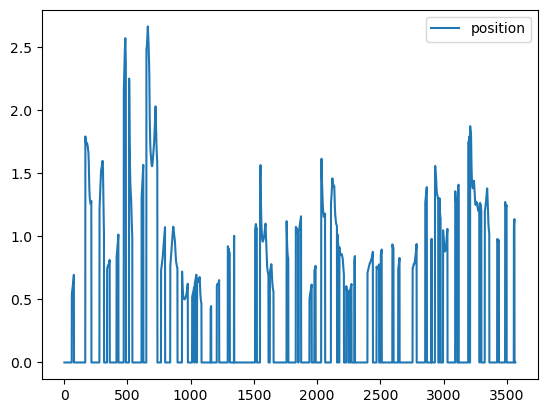

In [91]:
df[['position']].plot()

In [92]:
df.loc[df['Date']>='2015-10-07'].head(40)

Date       Close  Long Breakout_position  position  delta_position  \
279  2015-10-07  242.968994                1.220847  1.220847        1.220847   
280  2015-10-08  242.304001                1.243840  1.243840        0.022993   
281  2015-10-09  243.931000                1.266570  1.266570        0.022729   
282  2015-10-10  244.940994                1.290493  1.290493        0.023924   
283  2015-10-11  247.050003                1.315567  1.315567        0.025073   
284  2015-10-12  245.307999                1.341957  1.341957        0.026391   
285  2015-10-13  249.507996                1.369346  1.369346        0.027389   
286  2015-10-14  251.988998                1.397295  1.397295        0.027949   
287  2015-10-15  254.320007                1.424420  1.424420        0.027124   
288  2015-10-16  262.868988                1.452504  1.452504        0.028084   
289  2015-10-17  270.640015                1.481696  1.481696        0.029192   
290  2015-10-18  261.643005                1.502759  1.502759        0.021063   
291  2015-10-19  263.437012                1.519731  1.519731        0.016972   
292  2015-10-20  269.463013                1.523333  1.523333        0.003602   
293  2015-10-21  266.272003                1.529802  1.529802        0.006470   
294  2015-10-22  274.023010                1.535937  1.535937        0.006135   
295  2015-10-23  276.496002                1.541904  1.541904        0.005967   
296  2015-10-24  281.653992                1.545158  1.545158        0.003254   
297  2015-10-25  283.679993                1.551334  1.551334        0.006176   
298  2015-10-26  285.299988                1.558850  1.558850        0.007515   
299  2015-10-27  293.787994                1.569047  1.569047        0.010197   
300  2015-10-28  304.618011                1.581730  1.581730        0.012684   
301  2015-10-29  313.855011                1.591324  1.591324        0.009593   
302  2015-10-30  328.015015                1.595257  1.595257        0.003933   
303  2015-10-31  314.165985                1.598251  1.598251        0.002994   
304  2015-11-01  325.431000                1.593611  1.593611       -0.004640   
305  2015-11-02  361.188995                1.566966  1.566966       -0.026645   
306  2015-11-03  403.416992                1.542151  1.542151       -0.024815   
307  2015-11-04  411.562988                1.470697  1.470697       -0.071454   
308  2015-11-05  386.354004                1.378552  1.378552       -0.092145   
309  2015-11-06  374.470001                1.307155  1.307155       -0.071397   
310  2015-11-07  386.481995                1.232154  1.232154       -0.075001   
311  2015-11-08  373.368011                1.168330  1.168330       -0.063824   
312  2015-11-09  380.256989                1.117737  1.117737       -0.050593   
313  2015-11-10  336.819000                1.072973  1.072973       -0.044764   
314  2015-11-11  311.084015                1.037526  1.037526       -0.035447   
315  2015-11-12  338.152008                0.000000  0.000000       -1.037526   
316  2015-11-13  336.752991                0.000000  0.000000        0.000000   
317  2015-11-14  332.906006                0.000000  0.000000        0.000000   
318  2015-11-15  320.165985                0.000000  0.000000        0.000000   

     entry_mask  trade_id  
279           1       3.0  
280           0       3.0  
281           0       3.0  
282           0       3.0  
283           0       3.0  
284           0       3.0  
285           0       3.0  
286           0       3.0  
287           0       3.0  
288           0       3.0  
289           0       3.0  
290           0       3.0  
291           0       3.0  
292           0       3.0  
293           0       3.0  
294           0       3.0  
295           0       3.0  
296           0       3.0  
297           0       3.0  
298           0       3.0  
299           0       3.0  
300           0       3.0  
301           0       3.0  
302           0  

In [89]:
trades

Entry Date   Exit Date  Average Entry Price  Average Exit Price  \
0   2015-03-02  2015-03-19           277.073536          260.928009   
1   2015-06-17  2015-08-04           249.717548          282.740789   
2   2015-10-07  2015-11-12           247.301406          351.565345   
3   2015-12-06  2015-12-27           393.006649          422.854370   
4   2016-02-19  2016-03-05           422.240598          400.570007   
5   2016-04-16  2016-05-03           432.763285          450.318369   
6   2016-05-28  2016-06-23           530.039978          607.037075   
7   2016-09-04  2016-09-18           609.224483          609.874023   
8   2016-10-12  2017-01-07           659.606849          845.319872   
9   2017-02-05  2017-03-09          1061.042391         1188.489990   
10  2017-04-19  2017-06-15          1277.076485         2404.783635   
11  2017-07-21  2017-09-05          2924.462064         3950.498786   
12  2017-10-09  2017-10-25          4877.889844         5750.799805   
13  2017-10-30  2017-11-12          6215.705129         5950.069824   
14  2017-11-17  2017-12-22          7989.312755        14459.621580   
15  2018-03-04  2018-03-09         11465.134125         9337.549805   
16  2018-04-22  2018-05-11          8843.984979         8449.505008   
17  2018-07-18  2018-08-03          7374.113962         7459.676820   
18  2018-09-05  2018-09-07          6789.137262         6467.069824   
19  2019-02-19  2019-03-05          3946.819078         3894.916434   
20  2019-03-30  2019-06-05          4286.487495         6891.581682   
21  2019-06-16  2019-07-15          9116.483904        11020.381652   
22  2019-10-26  2019-11-09          9244.972656         8950.917671   
23  2020-01-07  2020-01-26          8166.215350         8596.686866   
24  2020-01-29  2020-02-18          9369.189872        10141.927657   
25  2020-04-24  2020-05-12          7770.411240         8804.477539   
26  2020-06-02  2020-06-12          9536.688016         9480.907658   
27  2020-07-26  2020-08-26          9967.031631        11469.901411   
28  2020-10-11  2020-11-28         11460.791101        17153.989143   
29  2020-12-01  2020-12-11         18802.998047        18159.679427   
30  2020-12-17  2021-01-22         22879.594768        33032.176634   
31  2021-02-09  2021-02-26         46560.910920        46408.285371   
32  2021-03-12  2021-03-23         57363.692190        54738.945312   
33  2021-04-14  2021-04-19         62997.492790        55724.265625   
34  2021-07-27  2021-09-08         40667.317329        46091.451014   
35  2021-10-07  2021-10-27         54134.493635        58415.442936   
36  2021-11-09  2021-11-17         66819.217167        60368.011719   
37  2022-02-09  2022-02-18         44337.589789        40112.189864   
38  2022-03-27  2022-04-07         46727.820529        43503.847656   
39  2022-07-19  2022-08-20         23360.743856        21174.470994   
40  2022-10-27  2022-11-09         20311.267995        15880.780273   
41  2022-12-14  2022-12-17         17792.555119        16795.091797   
42  2023-01-12  2023-02-07         18891.946245        23116.180224   
43  2023-02-16  2023-02-26         23623.474609        23661.815609   
44  2023-03-17  2023-04-21         27710.677910        27339.870653   
45  2023-06-21  2023-07-07         30038.876105        30349.162242   
46  2023-07-14  2023-07-18         30333.206548        29856.562500   
47  2023-10-02  2023-10-12         27529.656843        26756.798828   
48  2023-10-17  2023-12-30         29060.539408        39623.363919   
49  2024-01-02  2024-01-14         44953.786136        41945.027805   
50  2024-02-10  2024-03-17         48366.912117        67933.356223   
51  2024-05-18  2024-06-01         66963.330022        67728.444606   
52  2024-07-20  2024-08-01         67153.236377        65409.067951   
53  2024-09-27  2024-10-02         65693.854486        60632.785156   

    Trade Return     equity  
0      -0.058272   0.941728  
1       0.132242   1.066265  
2       

<Axes: >

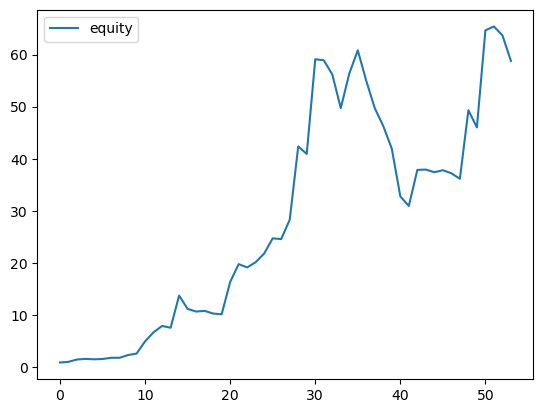

In [88]:
trades['equity'] = (trades['Trade Return']+1).cumprod()
trades[['equity']].plot()

In [65]:
import pandas as pd

# Sample DataFrame: replace with your actual DataFrame
# Assuming df has columns: 'Date', 'Close', 'Long Breakout_position'
df = strategy_1_positions.copy()

# Identify entry and exit points
df['Position_Change'] = df['Long Breakout_position'].diff()

# Create lists to store trade details
entries = []
exits = []
average_entry_prices = []
average_exit_prices = []
trade_returns = []

# Initialize variables for tracking trades
in_trade = False
entry_dates = []
entry_prices = []
entry_weights = []

for index, row in df.iterrows():
    # When entering a new trade (from 0 to non-zero position)
    if row['Position_Change'] > 0:
        in_trade = True
        entry_dates.append(row['Date'])
        entry_prices.append(row['Close'])
        entry_weights.append(row['Long Breakout_position'])
        print(entry_dates)

    # When accumulating positions (continuing a trade)
    elif in_trade and row['Long Breakout_position'] > 0:
        entry_dates.append(row['Date'])
        entry_prices.append(row['Close'])
        entry_weights.append(row['Long Breakout_position'])

    # When exiting a trade (from non-zero to 0 position)
    elif in_trade and row['Position_Change'] < 0:
        # Store entry data
        entries.append(entry_dates[0])
        
        # Calculate average entry price
        average_entry_price = sum(p * w for p, w in zip(entry_prices, entry_weights)) / sum(entry_weights)
        average_entry_prices.append(average_entry_price)

        # Store exit data
        exits.append(row['Date'])
        average_exit_prices.append(row['Close'])  # Exit price is the last price
        
        # Calculate trade return
        trade_return = (row['Close'] / average_entry_price) - 1
        trade_returns.append(trade_return)

        # Reset tracking variables
        in_trade = False
        entry_dates = []
        entry_prices = []
        entry_weights = []

# Create the trades DataFrame
trades_df = pd.DataFrame({
    'Entry_Date': entries,
    'Exit_Date': exits,
    'Average_Entry_Price': average_entry_prices,
    'Average_Exit_Price': average_exit_prices,
    'Trade_Return': trade_returns
})

#import ace_tools as tools; tools.display_dataframe_to_user(name="Trades DataFrame", dataframe=trades_df)


['2015-03-03']
['2015-03-03', '2015-03-04']
['2015-03-03', '2015-03-04', '2015-03-05']
['2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06']
['2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-07']
['2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-07', '2015-03-08']
['2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-07', '2015-03-08', '2015-03-09']
['2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-07', '2015-03-08', '2015-03-09', '2015-03-10']
['2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-07', '2015-03-08', '2015-03-09', '2015-03-10', '2015-03-11']
['2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-07', '2015-03-08', '2015-03-09', '2015-03-10', '2015-03-11', '2015-03-12']
['2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-07', '2015-03-08', '2015-03-09', '2015-03-10', '2015-03-11', '2015-03-12', '2015-03-13']
['2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03

In [63]:
trades_df

Empty DataFrame
Columns: [Entry_Date, Exit_Date, Average_Entry_Price, Average_Exit_Price, Trade_Return]
Index: []

In [59]:
import pandas as pd
import numpy as np

def calculate_trade_info(df):
    # Identify position changes
    position_changes = df['Long Breakout_position'].diff()
    entries = (position_changes != 0) & (df['Long Breakout_position'] != 0)
    exits = (position_changes != 0) & (df['Long Breakout_position'] == 0)
    
    # Create trade groups
    trade_groups = (entries | exits).cumsum()
    
    # Function to calculate trade info for each group
    def trade_info(group):
        entry_date = group.index[0]
        exit_date = group.index[-1]
        entry_price = group.loc[entry_date, 'Close']
        exit_price = group.loc[exit_date, 'Close']
        
        # Calculate average entry and exit prices
        avg_entry = (group['Close'] * group['Long Breakout_position'].diff().clip(lower=0)).sum() / group['Long Breakout_position'].diff().clip(lower=0).sum()
        avg_exit = (group['Close'] * group['Long Breakout_position'].diff().clip(upper=0).abs()).sum() / group['Long Breakout_position'].diff().clip(upper=0).abs().sum()
        
        # Calculate trade return
        trade_return = (avg_exit / avg_entry - 1) * np.sign(group['Long Breakout_position'].iloc[0])
        
        return pd.Series({
            'Entry Date': entry_date,
            'Exit Date': exit_date,
            'Average Entry Price': avg_entry,
            'Average Exit Price': avg_exit,
            'Trade Return': trade_return
        })
    
    # Apply the function to each trade group
    trades = df.groupby(trade_groups).apply(trade_info).reset_index(drop=True)
    
    return trades

# Apply the function to your dataframe
trade_info_df = calculate_trade_info(strategy_1_positions)

/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_23172/139857841.py:21: RuntimeWarning: invalid value encountered in scalar divide
  avg_entry = (group['Close'] * group['Long Breakout_position'].diff().clip(lower=0)).sum() / group['Long Breakout_position'].diff().clip(lower=0).sum()
/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_23172/139857841.py:22: RuntimeWarning: invalid value encountered in scalar divide
  avg_exit = (group['Close'] * group['Long Breakout_position'].diff().clip(upper=0).abs()).sum() / group['Long Breakout_position'].diff().clip(upper=0).abs().sum()
/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_23172/139857841.py:21: RuntimeWarning: invalid value encountered in scalar divide
  avg_entry = (group['Close'] * group['Long Breakout_position'].diff().clip(lower=0)).sum() / group['Long Breakout_position'].diff().clip(lower=0).sum()
/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_23172/139857841.py:22: RuntimeWarning: invalid v

In [60]:
trade_info_df

Entry Date  Exit Date  Average Entry Price  Average Exit Price  \
0           60.0       60.0                  NaN                 NaN   
1           61.0       61.0                  NaN                 NaN   
2           62.0       62.0                  NaN                 NaN   
3           63.0       63.0                  NaN                 NaN   
4           64.0       64.0                  NaN                 NaN   
...          ...        ...                  ...                 ...   
1259      3557.0     3557.0                  NaN                 NaN   
1260      3558.0     3558.0                  NaN                 NaN   
1261      3559.0     3559.0                  NaN                 NaN   
1262      3560.0     3560.0                  NaN                 NaN   
1263      3561.0     3561.0                  NaN                 NaN   

      Trade Return  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
1259           NaN  
1260           NaN  
1261           NaN  
1262           NaN  
1263           NaN  

[1264 rows x 5 columns]

In [26]:
# entry -> position goes from 0 to non-zero
# in position -> position is non-zero
# exit -> position goes from non-zero to zero

strategy_1_positions['Entry'] = np.nan
strategy_1_positions.loc[(strategy_1_positions['Long Breakout_position']!=0)]

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'SMA(Close, 20)', 'SMA(Close, 100)', 'vol_target_signal',
       'vol_target_position_size', 'vol_target_position', 'vol_target_returns',
       'vol_target_cumulative_equity', 'vol_target_cumulative_returns',
       'fixed_signal', 'fixed_position_size', 'fixed_position',
       'fixed_returns', 'fixed_cumulative_equity', 'fixed_cumulative_returns',
       'total_position', 'returns', 'gross_portfolio_returns', 'trades',
       'transaction_costs', 'portfolio_returns', 'cumulative_equity',
       'cumulative_market_equity', 'cumulative_returns',
       'cumulative_market_returns', 'portfolio_drawdown', 'market_drawdown',
       'vol_target_drawdown', 'fixed_drawdown', 'portfolio_rolling_sharpe',
       'market_rolling_sharpe', 'vol_target_rolling_sharpe',
       'fixed_rolling_sharpe'],
      dtype='object')

<Axes: >

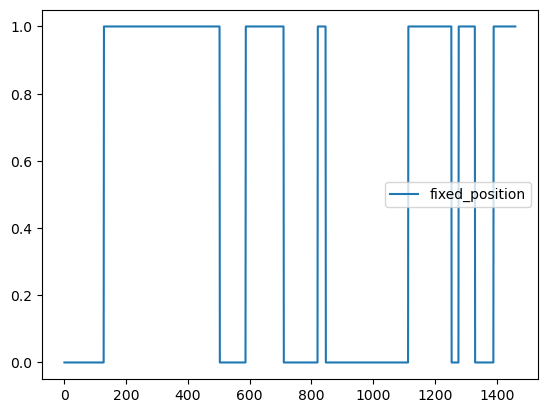

In [27]:
df[['fixed_position']].plot()

<Axes: >

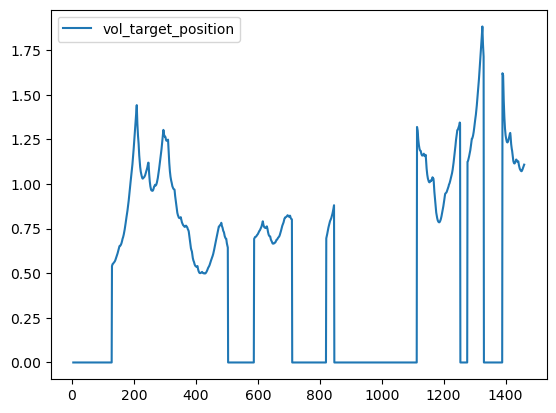

In [28]:
df[['vol_target_position']].plot()

<Axes: >

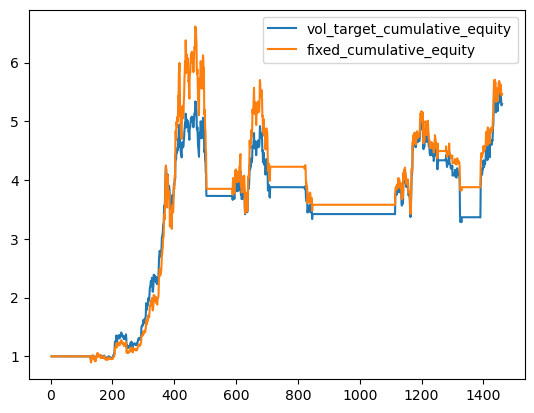

In [29]:
df[['vol_target_cumulative_equity', 'fixed_cumulative_equity']].plot()

In [30]:
df['realized_vol'] = df['Close'].pct_change().ewm(span=30).std().shift() * np.sqrt(365)
df['vol_estimate'] = df['realized_vol'].ewm(span=30).mean().shift()
df['position_size_2'] =0.7 / df['vol_estimate']

In [41]:
deviation = (df['vol_estimate'].shift() - 0.7).abs() / 0.7
adjust_condition = deviation > 0.2
# Adjust position sizes only when deviation exceeds buffer
df['position_size_3'] = df['position_size_2'].where(adjust_condition, np.nan)
# Forward-fill the position sizes when no adjustment is needed
df['position_size_3'].ffill(inplace=True)
# Limit the leverage between min and max leverage
#df['position_size_3'] = df['position_size_3'].clip(upper=1.0)
# Replace NaNs with previous position sizes
df['position_size_3'].fillna(method='ffill', inplace=True)

df['trades_3'] = df['position_size_3'].diff().abs()
df['costs_3'] = df['trades_3'] * (0.001 + 0.005)

df['trades_2'] = df['position_size_2'].diff().abs()
df['costs_2'] = df['trades_2'] * (0.001 + 0.005)

/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_23172/1374016408.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['position_size_3'].ffill(inplace=True)
/var/folders/y3/0zsjk4p155n75467q4v9b_j00000gn/T/ipykernel_23172/1374016408.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [42]:
df[['costs_2']].sum()

costs_2    0.106306
dtype: float64

In [43]:
df[['costs_3']].sum()

costs_3    0.087873
dtype: float64

<Axes: >

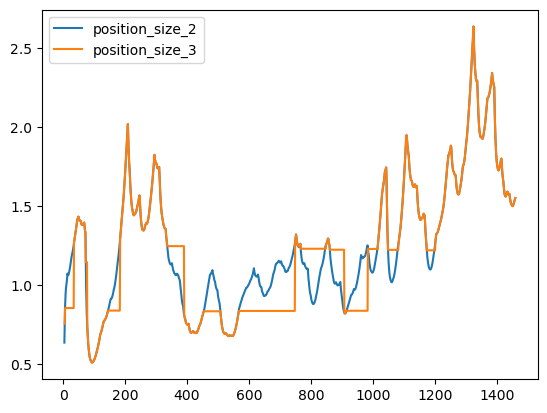

In [44]:
df[['position_size_2', 'position_size_3']].plot()

In [31]:
df[['realized_vol', 'vol_estimate']].head(30)

realized_vol  vol_estimate
0            NaN           NaN
1            NaN           NaN
2            NaN           NaN
3       1.097910           NaN
4       0.764142      1.097910
5       0.622738      0.925463
6       0.641352      0.817755
7       0.629082      0.769150
8       0.623717      0.737281
9       0.649855      0.715064
10      0.623459      0.703786
11      0.614017      0.691252
12      0.574651      0.680211
13      0.549743      0.666218
14      0.695111      0.651762
15      0.667052      0.656840
16      0.648612      0.657976
17      0.617606      0.656981
18      0.591068      0.652963
19      0.605817      0.646876
20      0.583322      0.642970
21      0.556638      0.637464
22      0.538649      0.630205
23      0.556080      0.622185
24      0.532281      0.616525
25      0.514586      0.609461
26      0.510366      0.601657
27      0.517337      0.594279
28      0.545565      0.588160
29      0.529798      0.584822

In [22]:
df[['transaction_costs']].sum()

transaction_costs    0.010833
dtype: float64

In [24]:
df['gross_cumulative_equity'] = (1 + df['gross_portfolio_returns']).cumprod()

df[['cumulative_equity', 'gross_cumulative_equity']]

cumulative_equity  gross_cumulative_equity
0                   NaN                      NaN
1                   NaN                      NaN
2                   NaN                      NaN
3                   NaN                      NaN
4                   NaN                      NaN
...                 ...                      ...
1456           5.455931                 5.515184
1457           5.344411                 5.402468
1458           5.271938                 5.329222
1459           5.279832                 5.337216
1460           5.294768                 5.352332

[1461 rows x 2 columns]

In [ ]:
df['signal']